In [150]:
from torch.utils.data import Dataset
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.cross_validation import train_test_split
from pretrainedmodels.models import bninception

import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import time

import matplotlib.pyplot as plt
from PIL import Image

import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np
import copy

random_seed = 4050
config_batch_size = 16
class_n = (9 + 10 + 26)
output_n = 9
num_epochs = 100
feature_extract = True
use_pretrained=True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

char_to_index = {"深":0, "秦":1, "京":2, "海":3, "成":4, "南":5, "杭":6, "苏":7, "松":8}
print(char_to_index)

{'深': 0, '秦': 1, '京': 2, '海': 3, '成': 4, '南': 5, '杭': 6, '苏': 7, '松': 8}


In [88]:
class CarIdDataset(Dataset):
    def __init__(self, data_list, weight = 229, height = 229):
        self.data_list = data_list
        self.weight = weight
        self.height = height

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self,index):
        img_path, label = self.data_list[index]["image_path"], self.data_list[index]["label"]
        img = np.array(Image.open(img_path))
        img = cv2.resize(img,(self.weight, self.height))
        img = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor()])(img)
        y = np.zeros([class_n * output_n])
        for i in range(len(label)):
            y[i * class_n + label[i]] = 1
        
        return img, y

In [89]:
label_file = "./data/train-data-label.txt"
image_file = "./data/train-data"
data_list = []
with open(label_file, 'r') as file_to_read:
    while True:
        lines = file_to_read.readline().strip() # 整行读取数据
        if not lines:
            break
        lines = lines.split(",  ")
        image_path = os.path.join(image_file, lines[1])
        label = [];
        label.append(char_to_index[lines[0][0]])
        for i in range(1, len(lines[0])):
            if '0' <= lines[0][i] and lines[0][i] <= '9':
                label.append(9 + ord(lines[0][i]) - ord('0'))
            else:
                label.append(9 + 10 + ord(lines[0][i]) - ord('A'))
        data_list.append({"image_path": image_path, "label":label})

(70, 296)
all_big_count =  16
x_big_count =  [0, 0, 64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 29, 29, 29, 25, 23, 23, 28, 36, 35, 32, 17, 17, 22, 29, 29, 29, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19, 30, 41, 45, 44, 39, 33, 28, 26, 25, 23, 21, 22, 26, 27, 28, 31, 37, 38, 43, 47, 49, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 30, 35, 37, 39, 41, 0, 0, 0, 16, 0, 0, 0, 16, 0, 16, 20, 32, 30, 28, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 44, 44, 44, 44, 44, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 25, 30, 31, 31, 30, 25, 19, 19, 24, 26, 28, 28, 28, 24, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 24, 31, 36, 40, 34, 22, 21, 17, 17, 16, 17, 17, 19, 22, 28, 39, 35, 30, 23, 0, 0, 0, 0, 0, 0, 0, 0, 44, 44, 44, 44, 44, 44, 0, 0, 0, 0, 0, 0, 0, 0, 19, 23, 22, 18, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 30, 35, 37, 39, 41, 0, 0, 0, 16, 0, 16, 20, 25, 24, 23, 23, 32, 30, 28, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 21, 26, 22, 21, 21, 20, 20, 21, 21, 24, 25, 25, 31, 28

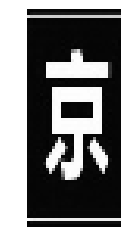

In [151]:
pixel_threshold = 255 / 2
width_threshold = 20
img = Image.open(data_list[0]["image_path"])
img = img.convert('L')
img = np.array(img)
print(img.shape)
h,w = img.shape
# make sure character is white
small_count, big_count = 0, 0
for i in range(h):
    for j in range(w):
        if img[i, j] < threshold:
            small_count += 1
        else:
            big_count += 1
if small_count < big_count:
    for i in range(h):
        for j in range(w):
            img[i, j] = 255 - img[i, j]

x_big_count = [0] * w
all_big_count = 0
for i in range(h):
    for j in range(w):
        if img[i, j] >= threshold:
            x_big_count[j] += 1;
            all_big_count += 1
all_big_count //= w
print("all_big_count = ", all_big_count)
for j in range(w):
    if x_big_count[j] < all_big_count:
        x_big_count[j] = 0
print("x_big_count = ", x_big_count)
print(data_list[0])
print(type(img))

plt.figure("love")
plt.imshow(img[:, 5:35], cmap='gray') # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

In [115]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs).double()
                    loss = criterion(outputs, labels)

                    for i in range(output_n):
                        _, preds = torch.max(outputs[:, i*class_n:(i+1)*class_n], 1)
                        _, y = torch.max(labels[:, i*class_n:(i+1)*class_n], 1)
                        running_corrects += torch.sum(preds == y)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                #running_corrects += torch.sum(preds == labels.data)

            print(len(dataloaders[phase].dataset))
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history
                
    return model

In [96]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [98]:
train_data_list, val_data_list, _, _ = train_test_split(data_list, data_list, test_size=0.22, random_state=random_seed)
train_gen = CarIdDataset(train_data_list)
train_loader = DataLoader(train_gen,batch_size=config_batch_size,shuffle=True,pin_memory=True,num_workers=2)

val_gen = CarIdDataset(val_data_list)
val_loader = DataLoader(val_gen,batch_size=config_batch_size,shuffle=False,pin_memory=True,num_workers=2)
dataloaders_dict = {"train":train_loader, "val":val_loader}

In [116]:
model_ft = models.alexnet(pretrained=use_pretrained)
set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs,class_n * output_n)
model_ft.to(device)

params_to_update = model_ft.parameters()
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
criterion = nn.BCEWithLogitsLoss().to(device)

model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/99
----------
3120
train Loss: 0.3412 Acc: 0.2551
880
val Loss: 0.1788 Acc: 0.3420

Epoch 1/99
----------
3120
train Loss: 0.1519 Acc: 0.3766
880
val Loss: 0.1314 Acc: 0.3545

Epoch 2/99
----------
3120
train Loss: 0.1252 Acc: 0.4144
880
val Loss: 0.1173 Acc: 0.3750

Epoch 3/99
----------
3120
train Loss: 0.1156 Acc: 0.4045
880
val Loss: 0.1111 Acc: 0.3716

Epoch 4/99
----------


KeyboardInterrupt: 